# Microbial community analysis for High P oil degradation project
The input data is abundance of microbes up to genus level for samples in different categories: 
    orig (original sediments)
    day0 (day 0 preincubation)
    sample (post-incubation)
Other info includes: OTU id, T, P, WaterDepth, Site name, Site ID, %Alk depletion, %PAH depletion, TOC, % Carbonate 

[I. Process the mothur exported files (0.03 taxonomy and 0.03 shared)](#I) <br>

[II. Community Analysis](#II) <br>
- [II-1. Taxonomic plots](#II-1)<br>

[III. Statistical Anlysis](#III)<br>

[IV. KEGG PICRUST analysis](#IV)<br>

[V.Regression model](#V) <br>
- [V-1. Model with all OTUs](#V1) <br>
- [V-2. Model with most abudant genera](#V2) <br>

In [1]:
import pandas as pd
import numpy as np
import csv
import string
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sns

## Process the mothur exported files (0.03 taxonomy and 0.03 shared) <a class="anchor" id="I"></a>

In [1019]:
with open("Oil_DNA_0.03.shared",'r') as f:
    lines = [line.rstrip() for line in f]

#Convert lines into data frame of OTU table count
shared = pd.DataFrame(columns=lines[0].split('\t')[1:])
for i in range(1,len(lines)):
    shared.loc[i-1] = lines[i].split('\t')[1:]
shared.drop('numOtus',1,inplace=True)
shared.rename(columns={'Group':'Sample'},inplace=True)

#Calculate abundances of taxa
#for i in range(shared.shape[0]):
    #shared.loc[i][1:] = shared.loc[i][1:].astype(int)/shared.loc[i][1:].astype(int).sum()
    
shared.to_csv("Oil_DNA_0.03_OTUtable_count.csv")

In [189]:
#Pivot the shared table so that it can be merged in the following steps
Abundance = []
for i in range(shared.shape[0]):
    Abundance += list(shared.loc[i][1:])

OTUs = list(shared.columns[1:]) * shared.shape[0]

Samples = []
for sample in shared['Sample']:
    Samples += [sample] * 14155 

shared_pivoted = pd.DataFrame({'OTU':OTUs,'Sample':Samples,'Abundance':Abundance})

In [225]:
#Import sample meta data
sample_map = pd.read_csv('Oil_DNA_map.csv')
sample_map.head()

,Group,Site,P,T,WD,TOC,Carb,Type,ALK,PAH,Pressure_regime,Temperature_regime
0,10a,PCB06,9.40,4.0,1008.0,1.706308,31.0,sample,56.650126,7.500000,High P,Low T
1,10b,PCB06,9.40,4.0,1008.0,1.706308,31.0,sample,53.768832,21.900000,High P,Low T
2,10c,PCB06,0.10,4.0,1008.0,1.706308,31.0,day0,0.000000,0.000000,High P,Low T
3,10orig,PCB06,9.40,4.0,1008.0,1.706308,31.0,orig,NaN,NaN,High P,Low T
4,13a,DSH10,15.28,4.0,1520.0,1.551581,20.3,sample,43.373744,35.716582,High P,Low T


In [122]:
with open("Oil_DNA_0_03.taxonomy",'r') as f:
    taxon = [line.rstrip() for line in f]
taxon[1].split(';')

['Otu00001\t17109\tBacteria(100)',
 'Proteobacteria(100)',
 'Gammaproteobacteria(100)',
 'Oceanospirillales(100)',
 'Halomonadaceae(100)',
 'unclassified(71)',
 '']

In [119]:
Otus = [row.split(";")[0].split('\t')[0] for row in taxon[1:]]
Domain = [row.split(";")[0].split('\t')[-1].split('(')[0] for row in taxon[1:]]
Phylum = [row.split(";")[1].split('(')[0] for row in taxon[1:]]
Class = [row.split(";")[2].split('(')[0] for row in taxon[1:]]
Order = [row.split(";")[3].split('(')[0] for row in taxon[1:]]
Family = [row.split(";")[4].split('(')[0] for row in taxon[1:]]
Genus = [row.split(";")[5].split('(')[0] for row in taxon[1:]]

In [125]:
taxontable = pd.DataFrame({'OTU':Otus,'Domain':Domain,'Phylum':Phylum,
                           'Class':Class,'Order':Order,'Family':Family,'Genus':Genus})
taxontable.to_csv("Oil_DNA_0.03_taxonomytable.csv")

In [226]:
# Merge all dfs to one and export to csv
merge_df = pd.merge(shared_pivoted,taxontable,on=['OTU'])
merge_df = pd.merge(merge_df,sample_map,left_on=['Sample'],right_on=['Group'])
merge_df.drop('Group',1,inplace=True)
merge_df.to_csv("Oil_DNA_0.03_combined_abundance.csv")

In [298]:
morethan1percent=merge_df[merge_df["Abundance"]>=0.005]

In [299]:
morethan1percent[morethan1percent['Phylum']=='unclassified']['OTU'].unique()

array(['Otu00416'], dtype=object)

## Community analysis <a class="anchor" id="II"></a>

In [6]:
# Import abundance data (calculated from R)
genus = pd.read_csv('oil_genus_all.csv',index_col=0)
genus_nona = genus.fillna(0)
genus.head()

,OTU,Sample,Abundance,Group,Site,P,T,WD,TOC,Carb,...,ALK,PAH,Pressure_regime,Temperature_regime,Kingdom,Phylum,Class,Order,Family,Genus
0,Otu02939,8orig,0.000564,8orig,SL9150,2.5,10.0,251.0,2.214079,32.1,...,NaN,NaN,Low P,High T,Bacteria,Planctomycetes,028H05-P-BN-P5,028H05-P-BN-P5_or,028H05-P-BN-P5_fa,028H05-P-BN-P5_ge
1,Otu02939,13c,0.000473,13c,DSH10,0.1,4.0,1520.0,1.551581,20.3,...,0.0,0.000000,High P,Low T,Bacteria,Planctomycetes,028H05-P-BN-P5,028H05-P-BN-P5_or,028H05-P-BN-P5_fa,028H05-P-BN-P5_ge
2,Otu02939,8c,0.000325,8c,SL9150,0.1,4.0,251.0,2.214079,32.1,...,0.0,0.000000,Low P,High T,Bacteria,Planctomycetes,028H05-P-BN-P5,028H05-P-BN-P5_or,028H05-P-BN-P5_fa,028H05-P-BN-P5_ge
3,Otu02939,4orig,0.000261,4orig,SL1460,2.5,20.0,212.0,1.433782,43.8,...,NaN,NaN,Low P,High T,Bacteria,Planctomycetes,028H05-P-BN-P5,028H05-P-BN-P5_or,028H05-P-BN-P5_fa,028H05-P-BN-P5_ge
4,Otu02939,1b,0.000187,1b,DSH08,11.1,4.0,1127.0,1.959001,26.1,...,60.0,19.525762,High P,Low T,Bacteria,Planctomycetes,028H05-P-BN-P5,028H05-P-BN-P5_or,028H05-P-BN-P5_fa,028H05-P-BN-P5_ge


In [7]:
genus.loc[genus[genus['OTU']=='Otu00007'].index,['Order','Family','Genus']]=['Pseudomonadales','Pseudomonadaceae','Pseudomonas']
genus.loc[genus[genus['OTU']=='Otu00014'].index,['Genus']]='Sulfitobacter'
genus.loc[genus[genus['OTU']=='Otu00011'].index,['Genus']]='Pseudomonas'
genus.loc[genus[genus['OTU']=='Otu00022'].index,['Genus']]='Olleya'
genus.loc[genus[genus['OTU']=='Otu00001'].index,['Genus']]='Halomonas'
genus.loc[genus[genus['OTU']=='Otu00023'].index,['Genus']]='Erythrobacter'
genus.loc[genus[genus['OTU']=='Otu02030'].index,'Phylum'] = 'Crenarchaeota'
genus.loc[genus[genus['OTU']=='Otu00392'].index,'Phylum'] ='Chloroflexi'

In [ ]:
df[(df['WD'].isin([1127, 1520, 1008])) & (df['P']==0.1) &(df['Type']=='sample')&(df['Abundance']>=0.01)].groupby(['Sample','Phylum']).sum().groupby('Phylum').mean()
df[(df['Type']=='sample') &(df['WD']<251)].groupby('Kingdom').sum()['Abundance']
df[df['Type']=='sample'].groupby(['Sample','Kingdom']).sum().groupby('Kingdom').mean()
df[df['P']<=2.5].groupby('Class').std()
df[df['P']>2.5].groupby('Class').mean()
df[(df['Class']=='Alphaproteobacteria')&(df['Family']=='unclassified') & (df['Abundance']>0.01)]

In [186]:
genus[(genus['Sample']=='13a')&(genus['Genus']=='Colwellia')]['OTU'].unique()

array(['Otu00002'], dtype=object)

In [187]:
genus[(genus['Sample']=='15a')&(genus['Genus']=='Colwellia')]['OTU'].unique()

array(['Otu00002'], dtype=object)

### Taxonomic plots  <a class="anchor" id="II-1"></a>

In [2]:
genus_colors=['#848484','#3d567f','#70b578','#8923c4','#ad4747','#e6b2ff',
              '#ff009d','#7f8400','#a3f2ff','#c1093a','#6b7cc6','#fc4cff','#0f8c01',
              '#ff8a00','#aeffa5','#cc8a3b','#ff7a9d','#ffd77a','#f9ffb2','#ff0202',
              '#00fff2','#3a51ff','#73f4d8','#fffa00','#ff6600','#00b2ff','#cb00ff',
              '#59ed28','#c7fce9','#d2d6d1','#d1cd9c','#9b6a47','#ff7777','#499b5a',
              '#c49c68','#349dad','#b200ff','#7c0048','#289bc9']


In [3]:
def append_unknown(dataframe):
    target_row = pd.DataFrame(dataframe.loc['unknown',:]).T
    dataframe.drop('unknown',inplace=True)
    dataframe = target_row.append(dataframe)
    return dataframe

def append_other_taxas(df1,df2,indexname):
    s_dict = {}
    for col in df1.columns:
        s_dict[col]=1-df1[col].sum() #df2[col].sum()
    s = pd.DataFrame(s_dict,index=[indexname])
    df1 = s.append(df1)
    return df1

In [4]:
def plot_clustered_stacked(dfall,genus_colors,level, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """
    Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
    labels is a list of the names of the dataframe, used for the legend title is a string for the title of the plot H is the hatch used for identification of the different dataframe
    dfall: list of dfs
    """

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0.8,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      edgecolor = 'black',
                      color=genus_colors,
                      figsize=(10,7),
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify

    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1.5) * i / float(n_col))
                rect.set_hatch(H * int((i-50) / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 2.5))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2)
    axe.set_xticklabels(df.index, rotation = 0,fontsize=14)#,ha='right')
    #axe.set_title(title)

    # Add invisible data to add another legend
    #n=[]        
    #for i in range(n_df):
        #n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1=axe.legend(h[::-1][n_col:], l[::-1][n_col:], loc='best', bbox_to_anchor=(1, 1))
    #l1=axe.legend(h[:n_col],l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, bbox_to_anchor=(1, 0.1))
    
    axe.add_artist(l1)
    plt.ylabel("%s abundance"%level,fontsize=13)

    return axe

In [152]:
df = genus#[genus['Class']=='Gammaproteobacteria']
level = 'Genus'

In [88]:
origs = df[df['Type']=='orig'][['WD',level,'Abundance']].sort_values(by='WD')
samples_a = df[(df['Type']=='sample')&(df['Sample'].str.contains('a'))][['WD',level,'Abundance']].sort_values(by='WD')
samples_b = df[(df['Type']=='sample')&(df['Sample'].str.contains('b'))][['WD',level,'Abundance']].sort_values(by='WD')
day0 = df[(df['Type']=='day0')&(df['Sample']!='14c')][['WD',level,'Abundance']].sort_values(by='WD')
control = df[df['Type']=='control'][['WD',level,'Abundance']].sort_values(by='WD')

origs_pivot=pd.pivot_table(origs,index=level,columns='WD',values='Abundance',aggfunc='sum')
day0_pivot = pd.pivot_table(day0,index=level,columns='WD',values='Abundance',aggfunc='sum')
samples_a_pivot = pd.pivot_table(samples_a,index=level,columns='WD',values='Abundance',aggfunc='sum')
samples_b_pivot = pd.pivot_table(samples_b,index=level,columns='WD',values='Abundance',aggfunc='sum')
control_pivot = pd.pivot_table(control,index=level,columns='WD',values='Abundance',aggfunc='sum')

In [58]:
samples_a_pivot.loc['Gammaproteobacteria']+samples_a_pivot.loc['Alphaproteobacteria']#+samples_b_pivot.loc['Deltaproteobacteria']

WD
62.0      0.805163
96.0      0.928493
150.0     0.867387
212.0     0.919201
251.0     0.735915
981.0     0.956817
1008.0    0.881552
1127.0    0.975319
1520.0    0.913094
dtype: float64

In [20]:
samples_a_pivot.loc['Proteobacteria'].describe()

count    9.000000
mean     0.899121
std      0.069759
min      0.739437
25%      0.883835
50%      0.919838
75%      0.932527
max      0.979921
Name: Proteobacteria, dtype: float64

In [159]:
samples_a = df[df['Sample'].isin(['1a','4a','7a','13a'])][['WD',level,'Abundance']].sort_values(by='WD')
samples_b = df[df['Sample'].isin(['1b','4b','7b','13b'])][['WD',level,'Abundance']].sort_values(by='WD')
control = df[df['Sample'].isin(['1d','4d','7d','13d'])][['WD',level,'Abundance']].sort_values(by='WD')
#dummy_b = df[df['Sample'].isin(['14b','15b','16b'])][['WD',level,'Abundance']].sort_values(by='WD')
day0 = df[df['Sample'].isin(['1c','4c','7c','13c'])][['WD',level,'Abundance']].sort_values(by='WD')
#orig = df[df['Sample'].isin(['1orig','10orig','13orig'])][['WD',level,'Abundance']].sort_values(by='WD')

samples_a_pivot =pd.pivot_table(samples_a,index=level,columns='WD',values='Abundance',aggfunc='sum')
samples_b_pivot  = pd.pivot_table(samples_b,index=level,columns='WD',values='Abundance',aggfunc='sum')
control_pivot  = pd.pivot_table(control,index=level,columns='WD',values='Abundance',aggfunc='sum')
#dummy_b_pivot = pd.pivot_table(dummy_b,index=level,columns='WD',values='Abundance',aggfunc='sum')
day0_pivot = pd.pivot_table(day0,index=level,columns='WD',values='Abundance',aggfunc='sum')
#orig_pivot = pd.pivot_table(orig,index=level,columns='WD',values='Abundance',aggfunc='sum')


In [181]:
table1a = samples_a_pivot.sort_values(by=[150],ascending=False).head(10).sort_values(by=150)
table1b = samples_a_pivot.sort_values(by=[1520],ascending=False).head(10).sort_values(by=150)
table1 = table1a.append(table1b)
table1.drop_duplicates(inplace=True)

table2 = samples_b_pivot.sort_values(by=[212],ascending=False).head(10)
table2 = table2.append( samples_b_pivot.loc[list(set(table1.index)-set(table2.index))])
table1 = samples_a_pivot.loc[list(set(table2.index)-set(table1.index))].append(table1)

table4 = day0_pivot.sort_values(by=[150],ascending=False).head(10)
table4 = table4.append(day0_pivot.loc[list(set(table1.index)-set(table4.index))])
table1 = samples_a_pivot.loc[list(set(table4.index)-set(table1.index))].append(table1).sort_values(by=150)

table3 = control_pivot.sort_values(by=[212],ascending=False).head(10)
table3 = table3.append(control_pivot.loc[list(set(table1.index)-set(table3.index))])
table1 = samples_a_pivot.loc[list(set(table3.index)-set(table1.index))].append(table1).sort_values(by=150)

table2 = table2.reindex(table1.index)
table4 = table4.reindex(table1.index)
table3 = table3.reindex(table1.index)
#table4 = dummy_b_pivot.loc[table1.index]
#table5 = day0_pivot.loc[table1.index]
[table1,table2,table3,table4] = [append_unknown(i) for i in [table1,table2,table3,table4]]

In [155]:
table1.head()

WD,150.0,212.0,1127.0,1520.0
unknown,0.018173,0.025303,0.060448,0.063731
Oceanospirillum,0.000000,0.000000,0.000000,0.000000
Salegentibacter,0.000000,0.000000,0.000418,0.000000
Gelidibacter,0.000000,0.000000,0.000000,0.035921
Moritella,0.000000,0.000000,0.003765,0.039397


In [182]:
table1 = append_other_taxas(table1,samples_a_pivot,'Others')
table2 = append_other_taxas(table2,samples_b_pivot,'Others')
table3 = append_other_taxas(table3,control_pivot,'Others')
table4 = append_other_taxas(table4,day0_pivot,'Others')
#table5 = append_other_taxas(table5,day0_pivot,'Others')
#table6 = append_other_taxas(table6,orig_pivot,'Others')

In [183]:
table1.columns = table1.columns.astype(int)
table2.columns = table2.columns.astype(int)
table3.columns = table3.columns.astype(int)
table4.columns = table4.columns.astype(int)
#table5.columns = table1.columns.astype(int)
#table6.columns = table1.columns.astype(int)

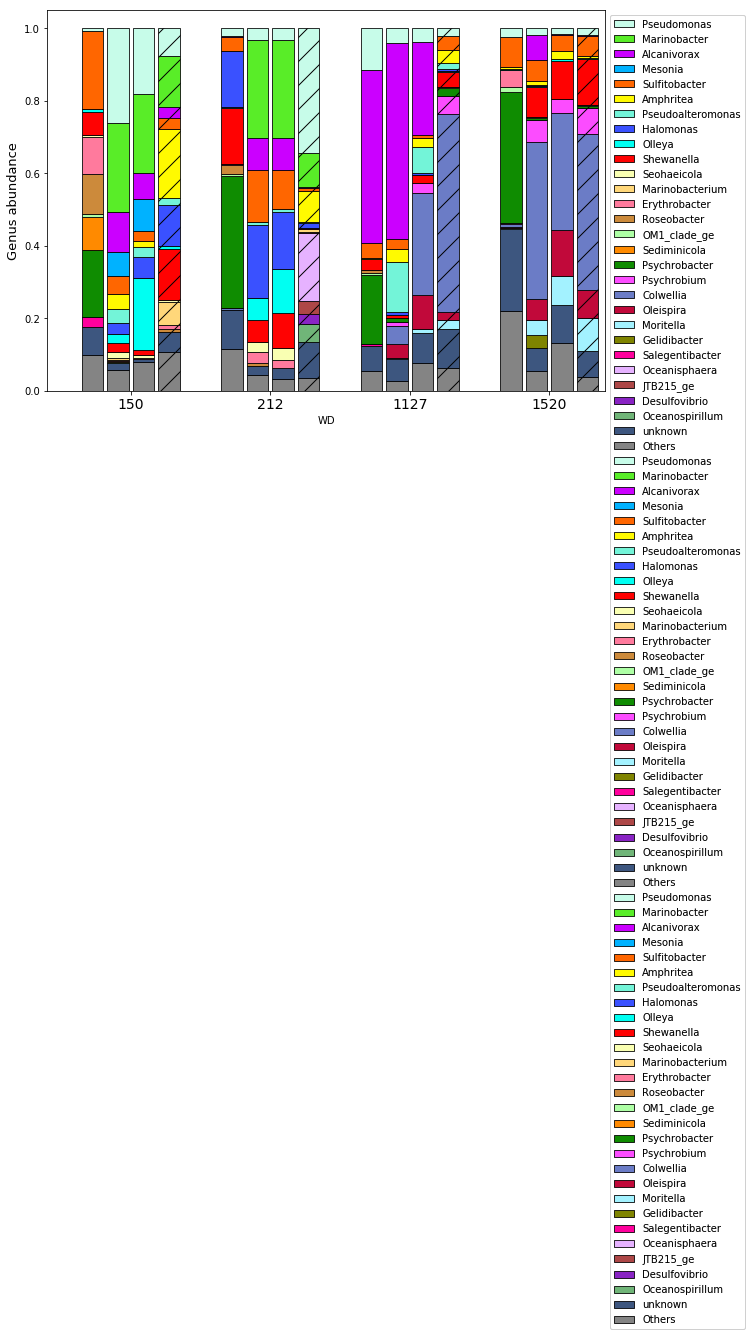

In [185]:
plot_clustered_stacked([table4.T,table1.T,table2.T,table3.T],genus_colors,level='Genus')
plt.savefig("Genus_control_groups.png",bbox_inches='tight',dpi=300)

In [39]:
genus['WD'].unique()

array([ 251., 1520.,  212., 1127.,   96.,   62.,  981.,  150.,   nan,
       1008.])

In [210]:
depth = 1127
subset = genus[genus['WD']==depth][['Sample','Genus','Abundance']]
subset_pivot=pd.pivot_table(subset,index='Genus',columns='Sample',values='Abundance',aggfunc='sum')
#subset_pivot.columns=subset_pivot.columns.astype(int)

In [211]:
sorted(subset['Sample'].unique(),reverse=True)

['1orig', '1d', '1c', '1b', '1a', '14c', '14b', '14a']

In [212]:
#orders = [62,96,150,212,251,981,1008,1127,1520]
#orders=['5a','5b','3a','3b','7a','7b','4a','4b','8a','8b',
        #'6a','6b','10a','10b','1a','1b','13a','13b']
#orders=['5orig','7orig','4orig','8orig','3orig','6orig','10orig','1orig','13orig']
orders = ['1orig', '1c', '14c','1d','1a','1b', '14a','14b']

In [216]:
xticklabels = ['original','day0_1','day0_2', 'no_oil','1a','1b', '14a','14b']

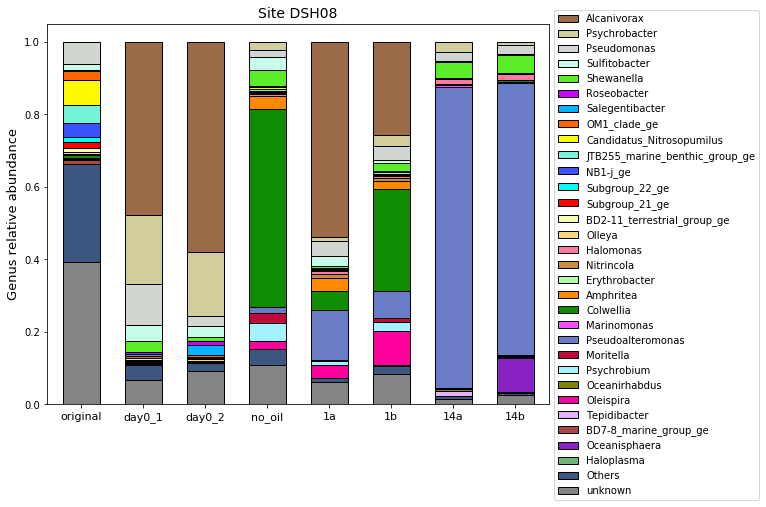

In [217]:
data_to_plot=pd.DataFrame()
for sample in orders:
     data_to_plot=data_to_plot.append(subset_pivot.sort_values(by=sample,ascending=False).head(11))

data_to_plot.drop_duplicates(inplace=True)
data_to_plot=data_to_plot.sort_values(by='1c')

s_dict = {}
for col in data_to_plot.columns:
    s_dict[col]=1-data_to_plot[col].sum()
s = pd.DataFrame(s_dict,index=['Others'])
data_to_plot = s.append(data_to_plot)

target_row = pd.DataFrame(data_to_plot.loc['unknown',:]).T
data_to_plot.drop('unknown',inplace=True)
data_to_plot = target_row.append(data_to_plot)

ax=data_to_plot.T.loc[orders].plot(kind='bar',stacked=True,figsize=(9,7),width = 0.6,
         edgecolor = 'black',legend=False,color=genus_colors)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', bbox_to_anchor=(1, 1.05))
ax.set_xlabel('')
ax.set_title('Site ' + genus[genus['WD']==depth]['Site'].iloc[0],fontsize=14)
fig=plt.xticks(np.arange(0,len(orders),1),xticklabels,rotation=0,fontsize=11)
#axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2)

plt.ylabel('Genus relative abundance',fontsize=13)
plt.savefig("Web_figs/1_Genus.jpg",bbox_inches='tight',dpi=300)

In [80]:
import plotly.graph_objs as go
import plotly.offline as pyo

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2015_06_30_precipitation.csv')

scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

data = [ dict(
    lat = df['Lat'],
    lon = df['Lon'],
    text = df['Globvalue'].astype(str) + ' inches',
    marker = dict(
        color = df['Globvalue'],
        colorscale = scl,
        reversescale = True,
        opacity = 0.7,
        size = 2,
        colorbar = dict(
            thickness = 10,
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
            ticks = "outside",
            ticklen = 3,
            showticksuffix = "last",
            ticksuffix = " inches",
            dtick = 0.1
        ),
    ),
    type = 'scattergeo'
) ]

layout = dict(
    geo = dict(
        scope = 'north america',
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 50,
        projection = dict(
            type = 'conic conformal',
            rotation = dict(
                lon = -100
            )
        ),
        lonaxis = dict(
            showgrid = True,
            gridwidth = 0.5,
            range= [ -140.0, -55.0 ],
            dtick = 5
        ),
        lataxis = dict (
            showgrid = True,
            gridwidth = 0.5,
            range= [ 20.0, 60.0 ],
            dtick = 5
        )
    ),
    title = 'US Precipitation 06-30-2015<br>Source: <a href="http://water.weather.gov/precip/">NOAA</a>',
)
fig = { 'data':data, 'layout':layout }
pyo.plot(fig)

'file:///Users/uyennguyen/Documents/GOM_microbialcommunities/temp-plot.html'

In [79]:
df['Globvalue'].describe()

count    10000.000000
mean         0.381026
std          0.158754
min          0.087500
25%          0.270800
50%          0.350000
75%          0.461700
max          1.330800
Name: Globvalue, dtype: float64

### Summarize at phylum level for each of category (sample, day0, orig) 

In [288]:
def get_mean(df,col,kind,level,n):
    '''
    This function create a DataFrame containing the mean of microbial composition
    at the chosen phylogenic level
        df: input dataframe
        kind: sample, orig, or day0
        level: taxonomic level
        n: number of rows wanted to print
    '''
    subdf= df[df[col]==kind].groupby(['Sample',level]).sum().groupby(level)['Abundance'].mean().sort_values(ascending=False).head(n).reset_index()
    return subdf

def get_stdev(df,col,kind,level,n):
    '''
    This function create a DataFrame containing standard deviation of microbial composition
    at the chosen phylogenic level
    '''
    subdf= df[df[col]==kind].groupby(['Sample',level]).sum().groupby(level)['Abundance'].std().sort_values(ascending=False).head(n).reset_index()
    return subdf

In [289]:
def summarize(df,col,kinds,level,n,func):
    '''
    col:'Type'
    kinds = ['orig','day0','sample']
    level: taxonomic level
    n: number of rows wanted to print
    func: mean or stdev
    '''
    if func == 'mean':
        dfs = [get_mean(df,col,kind,level,n) for kind in kinds]
    elif func == 'stdev':
        dfs = [get_stdev(df,col,kind,level,n) for kind in kinds]
    sum_df = reduce(lambda left,right: pd.merge(left,right,how='outer',on=level), dfs)
    sum_df.columns = [level]+kinds
    return sum_df


In [290]:
genus.columns

Index(['OTU', 'Sample', 'Abundance', 'Group', 'Site', 'P', 'T', 'WD', 'TOC',
       'Carb', 'Type', 'ALK', 'PAH', 'Pressure_regime', 'Temperature_regime',
       'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus'],
      dtype='object')

In [339]:
level='Genus'
kinds = ['orig','day0','sample','control']
n=20
col = 'Type'
sum_df = summarize(df[df['Phylum']=='Proteobacteria'],col,kinds,level,n,'mean')

In [340]:
sum_df[kinds] = round(100*sum_df[kinds],1)

In [341]:
sum_df

,Genus,orig,day0,sample,control
0,unknown,20.4,3.9,3.2,5.7
1,Pseudomonas,5.7,6.2,12.6,11.5
2,JTB255_marine_benthic_group_ge,4.3,0.6,NaN,NaN
3,Colwellia,3.9,0.4,7.9,24.4
4,NB1-j_ge,3.3,0.4,NaN,NaN
5,Sulfitobacter,2.9,6.9,4.3,3.3
6,KI89A_clade_ge,0.7,NaN,NaN,NaN
7,BD7-8_marine_group_ge,0.6,NaN,NaN,NaN
8,Desulfobulbus,0.6,NaN,NaN,NaN
9,Psychrobium,0.6,NaN,1.1,3.0


In [39]:
print(summarize(df,col,kinds,level,n,'mean'))
print(summarize(df,col,kinds,level,n,'stdev'))

    Kingdom      orig      day0   sample   control
0  Bacteria  0.890628  0.988648  0.99729  0.995319
1   Archaea  0.109373  0.011352  0.00271  0.004681
    Kingdom      orig      day0    sample   control
0  Bacteria  0.040892  0.012593  0.005368  0.005771
1   Archaea  0.040892  0.012593  0.005368  0.005771


In [ ]:
sum_df.set_index(level,inplace=True)
sum_df = sum_df.sort_values(by='Low T')

s_dict = {}
for col in sum_df.columns:
    s_dict[col]=1-sum_df[col].sum()
s = pd.DataFrame(s_dict,index=['Others'])
sum_df = s.append(sum_df)

target_row = pd.DataFrame(sum_df.loc['unknown',:]).T
sum_df.drop('unknown',inplace=True)
sum_df = target_row.append(sum_df)

Text(0,0.5,'Class composition (%)')

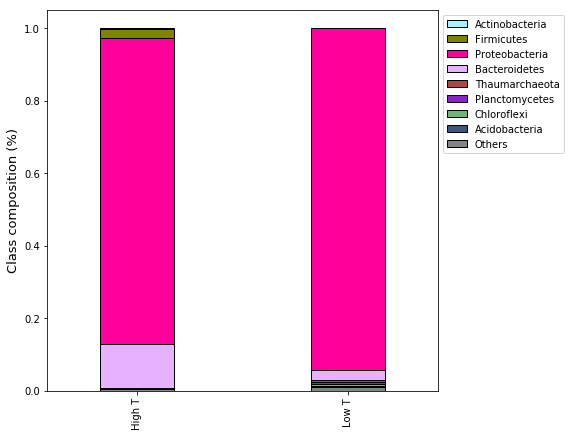

In [32]:
ax=sum_df.T.loc[['High T', 'Low T']].plot(kind='bar',stacked=True,figsize=(7,7),width = 0.35,
         edgecolor = 'black',legend=False,color=genus_colors)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', bbox_to_anchor=(1, 1))
#fig=plt.xticks(np.arange(9), rotation=90,fontsize=11)
plt.ylabel('Class composition (%)',fontsize=13)
#plt.savefig("Class_mean_compared.png",bbox_inches='tight',dpi=300)

In [38]:
df[(df['WD']==1008)&(df['P']>0.1)&(df['Type']=='sample')&(df['Class']=='Gammaproteobacteria')].groupby(['Genus'])['Abundance'].mean().sort_values(ascending=False).head(10)

Genus
Shewanella           0.209257
Psychrobacter        0.062515
Colwellia            0.052554
Oleispira            0.035395
Pseudoalteromonas    0.022875
Psychrobium          0.022613
Nitrincola           0.019418
Moritella            0.012475
unclassified         0.009551
Halomonadaceae_ge    0.002601
Name: Abundance, dtype: float64

In [105]:
a10 = df[(df['Sample']=='1a')&(df['Class']=='Gammaproteobacteria')].groupby('Genus')['Abundance'].sum().sort_values(ascending=False).head(10).reset_index()
b10 = df[(df['Sample']=='1b') &(df['Class']=='Gammaproteobacteria')].groupby('Genus')['Abundance'].sum().sort_values(ascending=False).head(10).reset_index()
ab10 = pd.merge(a10,b10,on=['Genus'])
ab10['Mean'] = (ab10['Abundance_x']+ab10['Abundance_y'])/2
ab10

,Genus,Abundance_x,Abundance_y,Mean
0,Alcanivorax,0.539218,0.257143,0.398180
1,Pseudoalteromonas,0.136373,0.072269,0.104321
2,unclassified,0.095587,0.096732,0.096159
3,Colwellia,0.051245,0.281979,0.166612
4,Amphritea,0.037649,0.023343,0.030496
5,Oleispira,0.036812,0.093557,0.065185
6,Psychrobacter,0.010667,0.031933,0.021300
7,Psychrobium,0.009621,0.027264,0.018443
8,Shewanella,0.005857,0.020915,0.013386


In [107]:
a15 = df[(df['Sample']=='14a') &(df['Class']=='Gammaproteobacteria')].groupby('Genus')['Abundance'].sum().sort_values(ascending=False).head(10).reset_index()
b15 = df[(df['Sample']=='14b') &(df['Class']=='Gammaproteobacteria')].groupby('Genus')['Abundance'].sum().sort_values(ascending=False).head(10).reset_index()
ab15 = pd.merge(a15,b15,on=['Genus'])
ab15['Mean'] = (ab15['Abundance_x']+ab15['Abundance_y'])/2
ab15

,Genus,Abundance_x,Abundance_y,Mean
0,Pseudoalteromonas,0.829341,0.751440,0.790390
1,unclassified,0.046847,0.050144,0.048496
2,Shewanella,0.042268,0.048944,0.045606
3,Psychrobacter,0.027122,0.008397,0.017760
4,Marinomonas,0.005107,0.001440,0.003273
5,Colwellia,0.004051,0.005758,0.004904
6,Moritella,0.003170,0.002639,0.002905


In [61]:
df[(df['WD'].isin([1127, 1520, 1008])) & (df['P']==0.1) &(df['Type']=='sample')&(df['Class']=='Gammaproteobacteria')].groupby('Genus')['Abundance'].std().sort_values(ascending=False).head(10)


Genus
Pseudoalteromonas    0.402690
Shewanella           0.154500
Colwellia            0.141723
Oleispira            0.060245
Moritella            0.052366
Oceanisphaera        0.037987
Alcanivorax          0.030640
unclassified         0.025386
Psychrobium          0.018557
Nitrincola           0.014913
Name: Abundance, dtype: float64

In [287]:
def comparelevel(df,kind,level1,level1name,level2,n):
    df1_mean = df[(df['WD']>252) & (df['P']>0.1) &(df['Type']==kind)&(df[level1]==level1name)].groupby(level2)['Abundance'].mean().sort_values(ascending=False).head(n).reset_index()
    df1_std = df[(df['WD']>252) & (df['P']>0.1) &(df['Type']==kind)&(df[level1]==level1name)].groupby(level2)['Abundance'].std().sort_values(ascending=False).head(20).reset_index()

    df2_mean = df[(df['WD']<=252)  & (df['Type']==kind)&(df[level1]==level1name)].groupby(level2)['Abundance'].mean().sort_values(ascending=False).head(20).reset_index()
    df2_std = df[(df['WD']<=252)  & (df['Type']==kind)&(df[level1]==level1name)].groupby(level2)['Abundance'].std().sort_values(ascending=False).head(20).reset_index()
    dfs = [df1_mean,df1_std,df2_mean,df2_std]
    merge = reduce(lambda left,right:pd.merge(left,right,how='outer',on=[level2]),dfs)
    merge.columns = [level2,'Deep_mean','Deep_std','Shallow_mean','Shallow_std']
    return merge


In [96]:
comparelevel(genus,'orig','Class','Gammaproteobacteria','Genus')

,Genus,Deep_mean,Deep_std,Shallow_mean,Shallow_std
0,JTB255_marine_benthic_group_ge,0.049738,0.008038,0.038269,0.008676
1,Colwellia,0.038422,0.023309,0.039484,0.027919
2,BD7-8_marine_group_ge,0.006947,0.003713,0.006137,0.002545
3,KI89A_clade_ge,0.005768,0.003928,0.007270,0.002685
4,uncultured_ge,0.005293,0.005551,0.003401,0.003362
5,Psychrobium,0.005140,0.003805,0.006835,0.006492
6,Moritella,0.004351,0.002407,0.003012,0.004042
7,OM182_clade_ge,0.003958,0.002648,0.002092,0.001469
8,Granulosicoccus,0.003902,0.004447,0.001848,NaN
9,Kangiella,0.003671,0.002548,0.001706,0.001692


In [81]:
comparelevel(df,'orig','Class','Alphaproteobacteria','Genus')

,Genus,Deep_mean,Deep_std,Shallow_mean,Shallow_std
0,unclassified,0.004245,0.008053,0.003504,0.009398
1,Sneathiella,0.002470,0.002603,NaN,NaN
2,Pelagibius,0.001932,0.001423,NaN,NaN
3,OCS116_clade_ge,0.001467,0.001378,0.001217,0.001505
4,uncultured,0.001362,0.003722,NaN,0.001638
5,AT-s3-44_ge,0.001190,0.001376,NaN,NaN
6,Methyloceanibacter,0.001173,0.002193,0.002521,0.001283
7,Erythrobacter,0.001088,0.001408,0.001228,0.001035
8,Filomicrobium,0.000912,0.001082,0.001591,0.001540
9,Emcibacter,0.000806,NaN,0.001094,NaN


In [78]:
comparelevel(df,'sample','Class','Deltaproteobacteria','Genus')

,Genus,Deep_mean,Deep_std,Shallow_mean,Shallow_std
0,NB1-j_ge,0.001701,0.001996,0.000122,0.000181
1,Haliangium,0.000169,0.000211,NaN,NaN
2,H16,0.000128,0.000290,NaN,NaN
3,P3OB-42_ge,0.000069,0.000194,NaN,NaN
4,Oligoflexaceae_ge,0.000067,0.000125,NaN,NaN
5,Peredibacter,0.000060,0.000113,NaN,NaN
6,Desulfatiglans,0.000034,0.000097,0.000073,0.000119
7,GBL17114_ge,0.000029,0.000082,NaN,NaN
8,uncultured,0.000028,0.000121,0.000069,0.000217
9,Sva0081_sediment_group,0.000026,NaN,0.000203,0.000310


## Statistic Analyses <a class="anchor" id="III"></a>

In [1023]:
import skbio
from skbio import DistanceMatrix
import numpy as np
from skbio.stats.distance import anosim
from sklearn.metrics import pairwise_distances as pw
from skbio.stats.distance import permanova
from scipy.cluster.hierarchy import dendrogram, linkage


In [ ]:
# Pivot table so that columns are OTUs, rows are samples, filled with Abundances of OTUs
#OTUs = pd.pivot_table(df[['Sample','OTU','Abundance']],values='Abundance',index='Sample',columns='OTU')
#OTUs = OTUs.reset_index()

In [1020]:
OTUcounts = pd.read_csv("Oil_DNA_0.03_OTUtable_count.csv",index_col=0)

In [1027]:
OTUcounts.head()

,Sample,Otu00001,Otu00002,Otu00003,Otu00004,Otu00005,Otu00006,Otu00007,Otu00008,Otu00009,...,Otu14147,Otu14148,Otu14149,Otu14150,Otu14151,Otu14152,Otu14153,Otu14154,Otu14155,Shannon
0,10a,973,257,652,124,1,0,0,3,156,...,0,0,0,0,0,0,0,0,0,4.080332
1,10b,922,148,867,56,0,0,1,47,111,...,0,0,0,0,0,0,0,0,0,3.488982
2,10c,2195,1,1,0,1,0,21,438,1,...,0,0,0,0,0,0,0,0,0,3.171230
3,10orig,0,158,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,9.514276
4,13a,5,743,140,3,99,0,0,10,100,...,0,0,0,0,0,0,0,0,0,4.034750


In [1026]:
OTUcounts['Shannon'] = OTUcounts.apply(lambda x:skbio.diversity.alpha.shannon(x[1:].astype('int')),axis=1)

In [1047]:
OTU_diversity = pd.merge(OTUcounts[['Sample','Shannon']],genus[['Sample','Site', 'P', 'T', 'WD', 'TOC',
       'Carb', 'Type', 'ALK', 'PAH', 'Pressure_regime', 'Temperature_regime']],how='left',on=['Sample'])
OTU_diversity.drop_duplicates(inplace=True)
OTU_diversity.shape

In [1096]:
samples=OTU_diversity[OTU_diversity['Type'].isin(['sample','dummy'])].sort_values(by='WD')
day0=OTU_diversity[OTU_diversity['Type']=='day0'].sort_values(by='WD')
orig=OTU_diversity[OTU_diversity['Type']=='orig'].sort_values(by='WD')
control = OTU_diversity[OTU_diversity['Type']=='control'].sort_values(by='WD')


In [342]:
def diversity_boxplot(dfs,index_type,labels,figsize=(8,5)):
    """
    This function plot boxplot of certain feature in each class of target variable
    - df: dataframe
    - col: feature column
    """
    # Create a figure instance
    fig = plt.figure(figsize=figsize)
    # Create an axes instance
    ax = fig.add_subplot(111)
    # Create the boxplot
    data_to_plot = [df[index_type].dropna() for df in dfs]    
    ax.boxplot(data_to_plot)
    ax.set_xticklabels(labels,fontsize=12)#,rotation=45)
    plt.ylabel("Shannon index",fontsize=14)



/Users/uyennguyen/anaconda3/envs/TEST/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


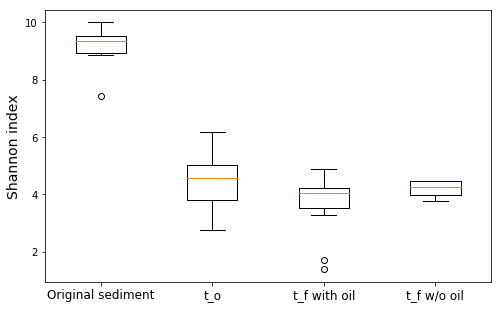

In [1065]:
diversity_boxplot([orig,day0,samples,control],'Shannon',['Original sediment','t_o','t_f with oil','t_f w/o oil'])
plt.savefig("Shannon_boxplot.png",dpi=300)

In [1119]:
samples['Order'] = np.repeat(np.arange(9)+1,[2,2,2,2,2,2,4,4,4])
orig['Order'] = np.repeat(np.arange(9)+1,1)
day0['Order'] = np.repeat(np.arange(9)+1,np.array([1,1,1,1,1,1,1,2,1]))
control['Order'] = [3,4,8,9]

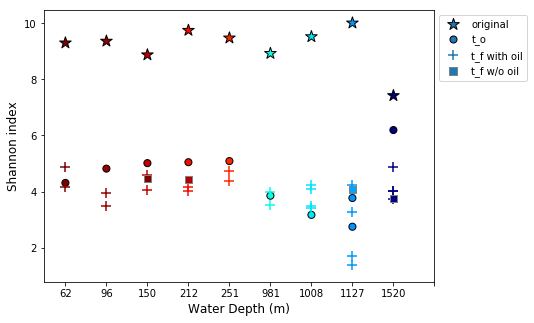

In [1177]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(orig['Order'],orig['Shannon'],marker='*',c=-orig['WD'],cmap='jet',edgecolor='black',s=150)
ax.scatter(day0['Order'],day0['Shannon'],marker='o',c=-day0['WD'],cmap='jet',edgecolor='black',s=50)
ax.scatter(samples['Order'],samples['Shannon'],marker='+',c=-samples['WD'],cmap='jet',edgecolor='grey',s=100)
ax.scatter(control['Order'],control['Shannon'],marker='s',c=-control['WD'],cmap='jet',edgecolor='grey',s=50)
ax.set_ylabel("Shannon index",fontsize=12)
ax.legend(labels=['original','t_o','t_f with oil','t_f w/o oil'],bbox_to_anchor=(1, 1))
ax.set_xticks(np.arange(10)+1)
ax.set_xticklabels(orig['WD'].astype(int))
ax.set_xlabel("Water Depth (m)",fontsize=12)
plt.savefig("Shannon_scatter.png",dpi=300,bbox_inches='tight')

In [1178]:
OTUs = pd.read_csv("Oil_DNA_0.03_OTUtable_abundance.csv",index_col=0)

In [1179]:
OTUs.head()

,Sample,Otu00001,Otu00002,Otu00003,Otu00004,Otu00005,Otu00006,Otu00007,Otu00008,Otu00009,...,Otu14146,Otu14147,Otu14148,Otu14149,Otu14150,Otu14151,Otu14152,Otu14153,Otu14154,Otu14155
0,10a,0.224659,0.059340,0.150543,0.028631,0.000231,0.0,0.000000,0.000693,0.036019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10b,0.278046,0.044632,0.261460,0.016888,0.000000,0.0,0.000302,0.014174,0.033474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10c,0.566890,0.000258,0.000258,0.000000,0.000258,0.0,0.005424,0.113120,0.000258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10orig,0.000000,0.046294,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13a,0.002897,0.430475,0.081112,0.001738,0.057358,0.0,0.000000,0.005794,0.057937,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1184]:
orig_deep = df[(df['Type']=='sample') & (df['WD']>500)]['Sample'].unique()
orig_shallow = df[(df['Type']=='sample') & (df['WD']<500)]['Sample'].unique()
deep = OTUs[OTUs['Sample'].isin(orig_deep)]
shallow = OTUs[OTUs['Sample'].isin(orig_shallow)]

In [100]:
#deep = OTUs[OTUs['Sample'].isin(['1a','1b'])]
#shallow = OTUs[OTUs['Sample'].isin(['13a','13b'])]

In [1185]:
OTU_df = pd.concat([deep,shallow])
OTU_df = OTU_df.set_index(keys='Sample')
OTU_mat = OTU_df.as_matrix()

In [1186]:
n = deep.shape[0]
m = shallow.shape[0]

In [1187]:
bc_dm = pw(OTU_mat,metric="braycurtis")
dm = DistanceMatrix(bc_dm,list(orig_deep) + list(orig_shallow))
grouping = ['Deep']*n + ['Shallow']*m
# make output deterministic; not necessary for normal use
np.random.seed(0)
anosim(dm, grouping, permutations=1000)

method name                    ANOSIM
test statistic name                 R
sample size                        18
number of groups                    2
test statistic               0.748973
p-value                   0.000999001
number of permutations           1000
Name: ANOSIM results, dtype: object

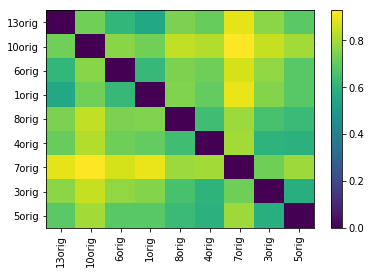

In [293]:
fig=dm.plot()
plt.savefig('Orig_deepvsshallow_distance.png',dpi=300)

In [255]:
permanova(dm, grouping, permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                       9
number of groups                  2
test statistic              2.47884
p-value                       0.007
number of permutations          999
Name: PERMANOVA results, dtype: object

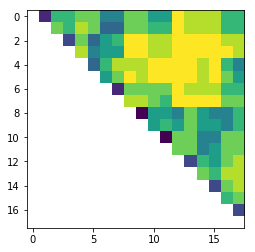

In [283]:
mask =  np.tri(bc_dm.shape[0], k=-1)
bc_dm = np.ma.array(bc_dm, mask=mask) 
fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = plt.cm.get_cmap('viridis', 10) # jet doesn't have white color
cmap.set_bad('w') # default value is 'k'
ax1.imshow(bc_dm, cmap=cmap)
ax1.grid(False)


## KEGG genes analysis (PICRUST) <a class="anchor" id="IV"></a>

In [ ]:
# Process the original kegg csv file to the desired format, with other info like P, T added
# This code was already run and produced new file that will be used for following analyses
#kegg = pd.read_csv("KEGG_output.csv")
#kegg.drop('Unnamed: 54',1,inplace=True)
#kegg_T = kegg.T
#kegg_T.columns = kegg_T.iloc[0]
#kegg_T.drop(kegg_T.index[0],inplace = True)
#kegg_T['Sample'] = kegg_T.index
#kegg_new = pd.merge(kegg_T,df[['Sample','P','T','WD','TOC','Carb','Type','ALK','PAH']],how='inner',on=['Sample'])
#kegg_new.drop_duplicates(['Sample'],inplace=True)
#kegg_new.col
#kegg_new.to_csv('Kegg_updated.csv')

In [188]:
# Import the updated Kegg file
kegg = pd.read_csv('Kegg_updated.csv',index_col=0)
kegg.head()

,"1,1,1-Trichloro-2,2-bis(4-chlorophenyl)ethane_(DDT)_degradation",ABC_transporters,Adherens_junction,Adipocytokine_signaling_pathway,African_trypanosomiasis,"Alanine,_aspartate_and_glutamate_metabolism",Aldosterone-regulated_sodium_reabsorption,Alzheimer's_disease,Amino_acid_metabolism,Amino_acid_related_enzymes,...,p53_signaling_pathway,Sample,P,T,WD,TOC,Carb,Type,ALK,PAH
0,172,123604,0,1722,589,32412,0,5491,6502,43187,...,802,10a,9.40,4,1008,1.706308,31.0,sample,56.650126,7.500000
806,211,98553,0,1285,381,23804,0,4096,4515,30489,...,502,10b,9.40,4,1008,1.706308,31.0,sample,53.768832,21.900000
1612,34,121956,0,1626,749,32140,0,5249,5979,41556,...,614,10c,0.10,4,1008,1.706308,31.0,day0,0.000000,0.000000
2418,34,132502,3,3765,525,47295,1,5084,13606,68630,...,512,10orig,9.40,4,1008,1.706308,31.0,orig,NaN,NaN
3224,89,33341,0,963,266,13392,0,2208,3828,17224,...,241,13a,15.28,4,1520,1.551581,20.3,sample,43.373744,35.716582


In [96]:
Naph = kegg[['WD','T','P','Type','PAH','Polycyclic_aromatic_hydrocarbon_degradation']]

In [97]:
Naph[Naph['Type']=='orig']['Polycyclic_aromatic_hydrocarbon_degradation'].mean()

4690.888888888889

In [98]:
Naph[Naph['Type']=='sample']['Polycyclic_aromatic_hydrocarbon_degradation'].mean()

3202.1666666666665

In [99]:
kegg['Benzoate_degradation'].mean()

4364.7

In [191]:
degradation=[]
for i in kegg.columns:
    if 'degradation' in i:
        degradation.append(i)
alk = []
for i in kegg.columns:
    if 'alkane' in i:
        alk.append(i)

In [207]:
alk

['Chloroalkane_and_chloroalkene_degradation']

In [204]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2



/Users/uyennguyen/anaconda3/envs/TEST/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


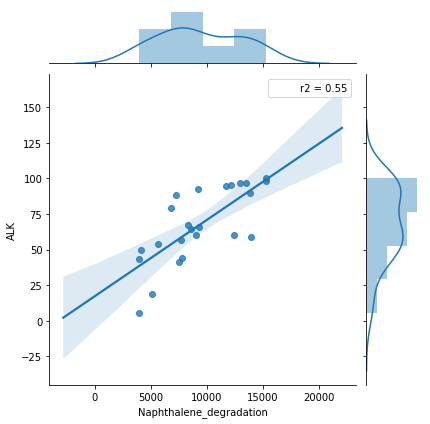

In [286]:
samples = kegg[kegg['Type']=='sample']
sns.jointplot('Naphthalene_degradation','ALK',data=samples,kind="reg", stat_func=r2)

In [193]:
def degradation_scatterplot(Type,gene,compound,color):
    samples = kegg[kegg['Type']==Type]
    plt.figure(figsize=(10,6))
    plt.scatter(samples[gene],samples[compound],c=-samples[color],cmap='jet',s=80)
    plt.xlabel('Normalized copies of genes',fontsize=12)
    plt.ylabel('%s depletion'%compound + " (%)",fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.colorbar(label=color)

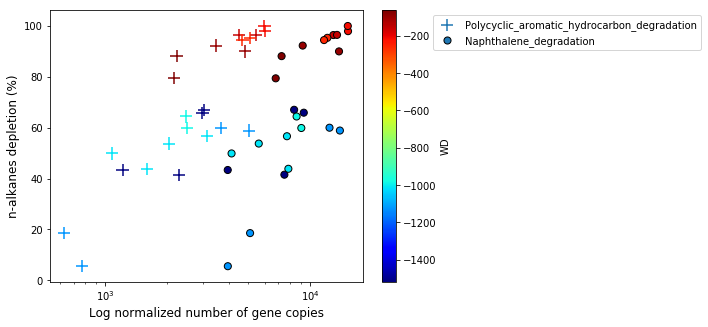

In [283]:
samples = kegg[kegg['Type']=='sample']
fig, ax = plt.subplots(figsize=(7,5))
col = 'ALK'
gene1 = 'Polycyclic_aromatic_hydrocarbon_degradation'
gene2 = 'Naphthalene_degradation'
im=ax.scatter(samples[gene1],samples[col],marker='+',c=-samples['WD'],cmap='jet',edgecolor='black',s=150)
ax.scatter(samples[gene2],samples[col],marker='o',c=-samples['WD'],cmap='jet',edgecolor='black',s=50)
#ax.scatter(samples['Order'],samples[gene],marker='+',c=-samples['WD'],cmap='jet',edgecolor='grey',s=100)
#ax.scatter(control['Order'],control[gene],marker='s',c=-control['WD'],cmap='jet',edgecolor='grey',s=50)
ax.set_xlabel("Log normalized number of gene copies",fontsize=12)
ax.legend(labels=[gene1,gene2],bbox_to_anchor=(2.1, 1))
#ax.set_xticks(np.arange(10)+1)
#ax.set_xticklabels(orig['WD'].astype(int))
ax.set_ylabel("n-alkanes depletion (%)",fontsize=12)
#plt.title(gene + " gene")
fig.colorbar(im, ax=ax,label='WD')
ax.set_xscale('log')
plt.savefig("ALK_gene.png",dpi=300,bbox_inches='tight')


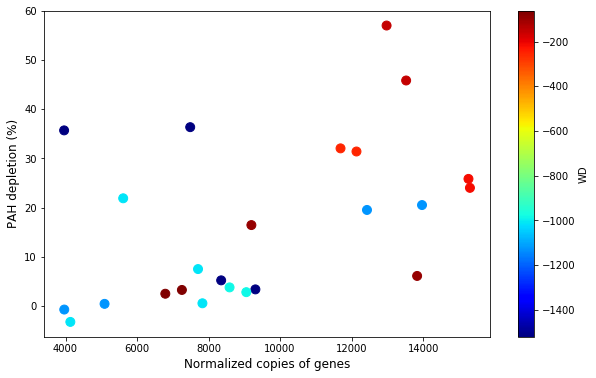

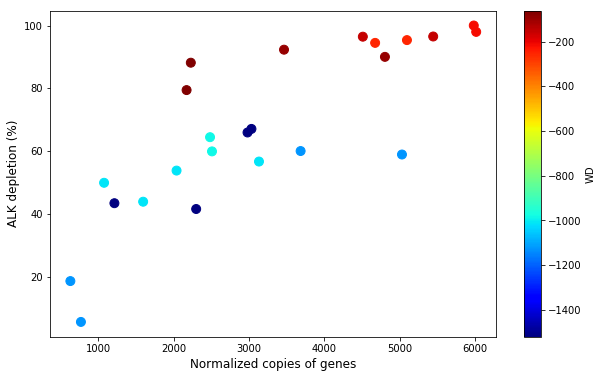

In [198]:
degradation_scatterplot('sample','Naphthalene_degradation','PAH','WD')
degradation_scatterplot('sample','Polycyclic_aromatic_hydrocarbon_degradation','ALK','WD')

In [1209]:
def all_scatterplot(gene):
    plt.figure(figsize=(10,6))
    plt.scatter(kegg[kegg['Type']=='orig']['WD'],kegg[kegg['Type']=='orig'][gene],label='orig',c='black',s=60)
    plt.scatter(kegg[kegg['Type']=='sample']['WD'],kegg[kegg['Type']=='sample'][gene],label='sample',c='blue',s=60)
    plt.scatter(kegg[kegg['Type']=='day0']['WD'],kegg[kegg['Type']=='day0'][gene],label='day0',c='red',s=60)
    plt.xlabel('Water depth (m)')
    plt.ylabel('Normalized copies of gene')
    plt.title(gene)
    plt.legend()
    

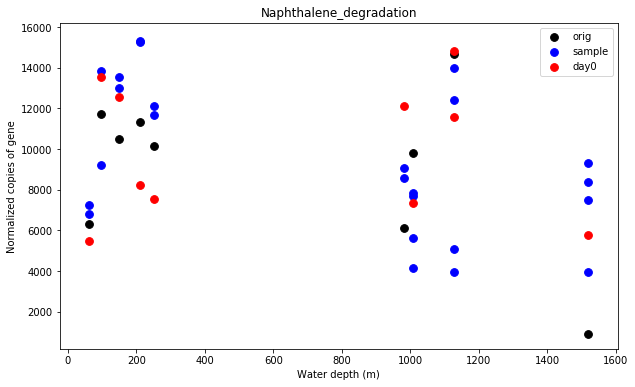

In [1214]:
all_scatterplot('Naphthalene_degradation')

In [234]:
degradation

['1,1,1-Trichloro-2,2-bis(4-chlorophenyl)ethane_(DDT)_degradation',
 'Aminobenzoate_degradation',
 'Atrazine_degradation',
 'Benzoate_degradation',
 'Biosynthesis_and_biodegradation_of_secondary_metabolites',
 'Bisphenol_degradation',
 'Caprolactam_degradation',
 'Chloroalkane_and_chloroalkene_degradation',
 'Chlorocyclohexane_and_chlorobenzene_degradation',
 'Dioxin_degradation',
 'Ethylbenzene_degradation',
 'Fluorobenzoate_degradation',
 'Geraniol_degradation',
 'Glycosaminoglycan_degradation',
 'Limonene_and_pinene_degradation',
 'Lysine_degradation',
 'Naphthalene_degradation',
 'Nitrotoluene_degradation',
 'Other_glycan_degradation',
 'Polycyclic_aromatic_hydrocarbon_degradation',
 'RNA_degradation',
 'Styrene_degradation',
 'Synthesis_and_degradation_of_ketone_bodies',
 'Toluene_degradation',
 'Valine,_leucine_and_isoleucine_degradation',
 'Xylene_degradation']

In [363]:
samples = kegg[(kegg['Type']=='sample')].sort_values(by='WD')
orig = kegg[kegg['Type']=='orig'].sort_values(by='WD')
day0 = kegg[kegg['Type']=='day0'].sort_values(by='WD')
control = kegg[kegg['Type']=='control'].sort_values(by='WD')
samples['Order'] = np.repeat(np.arange(9)+1,[2,2,2,2,2,2,4,4,4])
orig['Order'] = np.repeat(np.arange(9)+1,1)
day0['Order'] = np.repeat(np.arange(9)+1,np.array([1,1,1,1,1,1,1,2,1]))
control['Order'] = [3,4,8,9]
#&(~kegg['Sample'].isin(['16a','16b','15a','15b','14a','14b']))

In [369]:
gene = 'Polycyclic_aromatic_hydrocarbon_degradation'

Text(0.5,1,'Naphthalene_degradation gene')

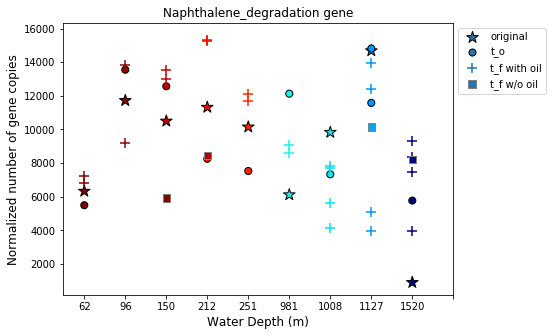

In [366]:
fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(orig['Order'],orig[gene],marker='*',c=-orig['WD'],cmap='jet',edgecolor='black',s=150)
ax.scatter(day0['Order'],day0[gene],marker='o',c=-day0['WD'],cmap='jet',edgecolor='black',s=50)
ax.scatter(samples['Order'],samples[gene],marker='+',c=-samples['WD'],cmap='jet',edgecolor='grey',s=100)
ax.scatter(control['Order'],control[gene],marker='s',c=-control['WD'],cmap='jet',edgecolor='grey',s=50)
ax.set_ylabel("Normalized number of gene copies",fontsize=12)
ax.legend(labels=['original','t_o','t_f with oil','t_f w/o oil'],bbox_to_anchor=(1, 1))
ax.set_xticks(np.arange(10)+1)
ax.set_xticklabels(orig['WD'].astype(int))
ax.set_xlabel("Water Depth (m)",fontsize=12)
plt.title(gene + " gene")
#plt.savefig("benzoate_degrading_scatter.png",dpi=300,bbox_inches='tight')

/Users/uyennguyen/anaconda3/envs/TEST/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


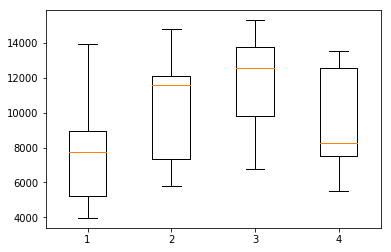

In [367]:
f = plt.boxplot([samples[samples['WD']>500][gene],day0[day0['WD']>500][gene],samples[samples['WD']<500][gene],day0[day0['WD']<500][gene]])

In [370]:
#import scipy
print(scipy.stats.ttest_ind(samples[samples['WD']>500][gene],samples[samples['WD']<500][gene]))
print(scipy.stats.ttest_ind(day0[day0['WD']>500][gene],day0[day0['WD']<500][gene]))

Ttest_indResult(statistic=-3.9476958189600797, pvalue=0.00068511495832152111)
Ttest_indResult(statistic=-0.36111702719367667, pvalue=0.72736251457160783)


## Regression model <a class="anchor" id="V"></a>

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

### Building model with all OTUs <a class="anchor" id="V1"></a>

In [3]:
otus = pd.read_csv("Oil_DNA_0.03_combined_abundance.csv",index_col=0)
otus.loc[otus[otus['OTU']=='Otu00007'].index,['Order','Family','Genus']]=['Pseudomonadales','Pseudomonadaceae','Pseudomonas']
otus.loc[otus[otus['OTU']=='Otu00014'].index,['Genus']]='Sulfitobacter'
otus.loc[otus[otus['OTU']=='Otu00011'].index,['Genus']]='Pseudomonas'
otus.loc[otus[otus['OTU']=='Otu00022'].index,['Genus']]='Olleya'
otus.loc[otus[otus['OTU']=='Otu00001'].index,['Genus']]='Halomonas'
otus.loc[otus[otus['OTU']=='Otu00023'].index,['Genus']]='Erythrobacter'
otus.loc[otus[otus['OTU']=='Otu02030'].index,'Phylum'] = 'Crenarchaeota'
otus.loc[otus[otus['OTU']=='Otu00392'].index,'Phylum'] ='Chloroflexi'
otus.loc[otus[otus['OTU']=='Otu00123'].index,['Family','Genus']]=['Pseudoalteromonadaceae','Pseudoalteromonas']
otus.loc[otus[otus['OTU']=='Otu00119'].index,['Genus']]='Colwellia'
otus.head()


/Users/uyennguyen/anaconda3/envs/TEST/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Abundance,OTU,Sample,Class,Domain,Family,Genus,Order,Phylum,Site,P,T,WD,TOC,Carb,Type,ALK,PAH,Pressure_regime,Temperature_regime
0,0.224659,Otu00001,10a,Gammaproteobacteria,Bacteria,Halomonadaceae,Halomonas,Oceanospirillales,Proteobacteria,PCB06,9.4,4.0,1008.0,1.706308,31.0,sample,56.650126,7.5,High P,Low T
1,0.059340,Otu00002,10a,Gammaproteobacteria,Bacteria,Colwelliaceae,Colwellia,Alteromonadales,Proteobacteria,PCB06,9.4,4.0,1008.0,1.706308,31.0,sample,56.650126,7.5,High P,Low T
2,0.150543,Otu00003,10a,Gammaproteobacteria,Bacteria,Shewanellaceae,Shewanella,Alteromonadales,Proteobacteria,PCB06,9.4,4.0,1008.0,1.706308,31.0,sample,56.650126,7.5,High P,Low T
3,0.028631,Otu00004,10a,Gammaproteobacteria,Bacteria,Pseudoalteromonadaceae,Pseudoalteromonas,Alteromonadales,Proteobacteria,PCB06,9.4,4.0,1008.0,1.706308,31.0,sample,56.650126,7.5,High P,Low T
4,0.000231,Otu00005,10a,Gammaproteobacteria,Bacteria,Alcanivoracaceae,Alcanivorax,Oceanospirillales,Proteobacteria,PCB06,9.4,4.0,1008.0,1.706308,31.0,sample,56.650126,7.5,High P,Low T


In [4]:
samples = otus[(otus['Type'].isin(['sample','dummy']))]
samples_pivot = pd.pivot_table(samples,values='Abundance',columns='Sample',index='OTU',aggfunc='sum')

In [18]:
samples.columns

Index(['Abundance', 'OTU', 'Sample', 'Class', 'Domain', 'Family', 'Genus',
       'Order', 'Phylum', 'Site', 'P', 'T', 'WD', 'TOC', 'Carb', 'Type', 'ALK',
       'PAH', 'Pressure_regime', 'Temperature_regime'],
      dtype='object')

In [5]:
genera = []
for i in samples_pivot.T.index:
    genera += list(samples_pivot.T.loc[i][samples_pivot.T.loc[i]>0].index)
genera = list(set(genera))
genera.sort()
len(genera)

3833

In [6]:
samples_select = samples_pivot.loc[genera]
samples_select_T = samples_select.T.reset_index()
samples_merge = pd.merge(samples_select_T,samples[['Sample','T','P','ALK','PAH','TOC','WD']],how='left',on=['Sample'])
samples_merge.drop_duplicates(inplace=True)
samples_merge.shape

(24, 3840)

In [7]:
data=np.array(samples_merge.drop(['Sample','T','P','ALK','PAH','TOC','WD'],1))
data.shape

(24, 3833)

In [457]:
#scaler = StandardScaler()
#scaler.fit(samples_merge.drop(['Sample','T','P','ALK','PAH','WD'],1))
#scaled_data = scaler.transform(samples_merge.drop(['Sample','T','P','ALK','PAH','WD'],1))
#pca = PCA(n_components=2)
#pca.fit(scaled_data)
#x_pca = pca.transform(scaled_data)

In [37]:
n = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
variance=[]
for i in n:
    pca = PCA(n_components=i)
    pca.fit(data)
    variance.append(1-np.sum(pca.explained_variance_ratio_))
    

Text(0,0.5,'Fraction of variance not explained')

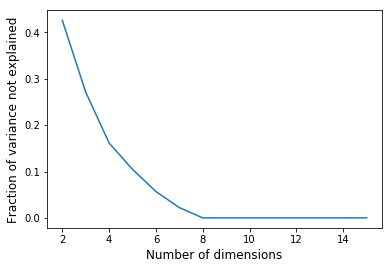

In [38]:
plt.plot(n,variance)
plt.xlabel("Number of dimensions",fontsize=12)
plt.ylabel("Fraction of variance not explained",fontsize=12)
#plt.savefig("PCA_screeplot.png",dpi=300)

In [8]:
pca = PCA(n_components=6)
pca.fit(data)
x_pca = pca.transform(data)
pca.explained_variance_ratio_

array([ 0.36507739,  0.21414389,  0.14808162,  0.09161929,  0.05519554,
        0.04561594])

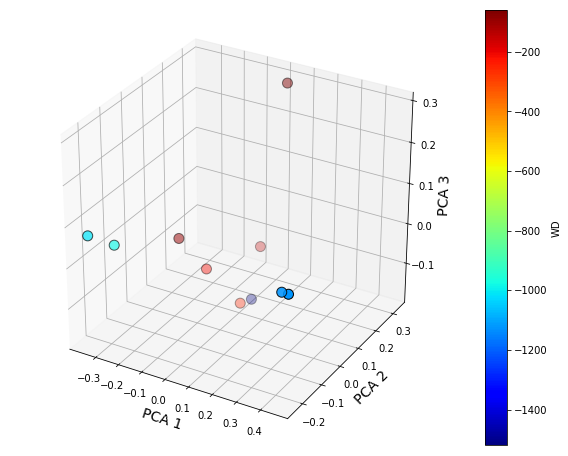

In [72]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

im=ax.scatter(x_pca[:,0],x_pca[:,1],x_pca[:,2],c=np.array(-samples_merge['WD']),cmap='jet',s=100,edgecolors='black')
ax.set_xlabel('PCA 1',fontsize=14)
ax.set_ylabel('PCA 2',fontsize=14)
ax.set_zlabel('PCA 3',fontsize=14)
fig.colorbar(im, ax=ax,label='WD')
#plt.savefig("PCA_allsamples.png",dpi=300)

In [251]:
samples_merge.columns

Index(['Sample', 'Otu00001', 'Otu00002', 'Otu00003', 'Otu00004', 'Otu00005',
       'Otu00006', 'Otu00007', 'Otu00008', 'Otu00009',
       ...
       'ALK', 'PAH', 'TOC', 'WD', 'PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5',
       'PCA6'],
      dtype='object', length=3217)

In [255]:
df_comp = pd.DataFrame(pca.components_,columns=samples_merge.drop(['Sample','T','P','ALK','PAH','TOC','WD'],1).columns)
#plt.figure(figsize=(20,6))
#sns.heatmap(df_comp,cmap='jet')

In [9]:
samples_merge['PCA1']=x_pca[:,0]
samples_merge['PCA2']=x_pca[:,1]
samples_merge['PCA3']=x_pca[:,2]
samples_merge['PCA4']=x_pca[:,3]
samples_merge['PCA5']=x_pca[:,4]
samples_merge['PCA6']=x_pca[:,5]


In [109]:
#samples = otus[(otus['Type'].isin(['sample','dummy']))][['Sample','T','P','ALK','PAH','TOC','WD']]
#samples.drop_duplicates(inplace=True)
#datatomodel = pd.merge(samples,samples_merge[['PCA1','PCA2','PCA3','WD']],on=['WD'])
#datatomodel.drop([9,11,12,14],0,inplace=True)

In [10]:
datatomodel = samples_merge

In [24]:
test_all = pd.merge(datatomodel,samples_merge[['WD','PCA4','PCA5','PCA6']],on=['WD'])
test_all.drop([9,11,12,14],0,inplace=True)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(datatomodel[['PCA1','PCA2','PCA3','T','P','TOC']],
                                                    datatomodel['PAH'],test_size=0, random_state=1)
rf = RandomForestRegressor(n_estimators=10000,oob_score=True,min_samples_leaf=2,min_samples_split=5,max_features=3)
rf.fit(X_train,y_train)
#lr = LinearRegression()
#lr.fit(X_train,y_train)
#knn = KNeighborsRegressor(n_neighbors=2)
#knn.fit(X_train,y_train)
#dt = DecisionTreeRegressor()
#dt.fit(X_train,y_train)
#scores = cross_val_score(rf,X_train,y_train, cv=5)
print(rf.feature_importances_)

#y_pred = rf.predict(X_test)
#print(mean_squared_error(y_test,y_pred))
print(rf.oob_score_)
print(np.mean(rf.oob_prediction_))

[ 0.03721161  0.09774117  0.25243585  0.02404008  0.31050945  0.27806184]
0.583568083816
16.2467509341


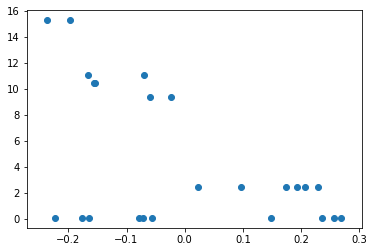

In [19]:
plt.scatter(datatomodel['PCA2'],datatomodel['P'])

In [115]:
dt.feature_importances_

array([ 0.25612469,  0.02095158,  0.01556384,  0.66671271,  0.04064717])

In [90]:
rf_pred = rf.predict(X_train)
lr_pred = lr.predict(X_train)
knn_pred = knn.predict(X_train)
print(mean_squared_error(y_train,rf_pred))
print(mean_squared_error(y_train,lr_pred))
print(mean_squared_error(y_train,knn_pred))


37.8711657175
83.2993569614
6.8103057941


In [259]:
def get_loadings(df_comp,otus,i,kind):
    if kind == 'pos':
        PCA_otus=df_comp.loc[i][df_comp.loc[i]>0.01].reset_index().sort_values(by=i,ascending=True)
    else:
        PCA_otus=df_comp.loc[i][df_comp.loc[i]<-0.01].reset_index().sort_values(by=i,ascending=True)
    
    PCA_otus.columns=['OTU','loading']
    PCA_otus.columns=['OTU','loading']
    families = []
    genus = []
    for i in list(PCA_otus['OTU']):
        families += list(otus[otus['OTU']==i]['Family'].head(1))
        genus += list(otus[otus['OTU']==i]['Genus'].head(1))
    PCA_otus['Family']= families
    PCA_otus['Genus']=genus
    
    return PCA_otus

PCA1_otu_pos = get_loadings(df_comp,otus,0,'pos')
PCA1_otu_neg = get_loadings(df_comp,otus,0,'neg')
PCA2_otu_pos = get_loadings(df_comp,otus,1,'pos')
PCA2_otu_neg = get_loadings(df_comp,otus,1,'neg')
PCA3_otu_pos = get_loadings(df_comp,otus,2,'pos')
PCA3_otu_neg = get_loadings(df_comp,otus,2,'neg')

In [218]:
PCA3_otu_pos.loc[12] = ['Otu00123',0.0152521,'Pseudoalteromonadaceae','Pseudoalteromonas']

In [233]:
def plot_heatmapPCA(PCA_otu_pos,PCA_otu_neg,col):
    PCA_otu= PCA_otu_pos.append(PCA_otu_neg)
    PCA_otu_T = PCA_otu[[col,'loading']].T
    PCA_otu_T.columns = PCA_otu_T.loc[col]
    PCA_otu_T.drop(col,0,inplace=True)
    return PCA_otu_T
   

In [228]:
PCA2_otu_pos.loc[9] = ['Otu00029',0.0627701,'Flavobacteriaceae','Xanthomarina']

Text(0.5,14.0938,'OTUs that have most significant loading factors')

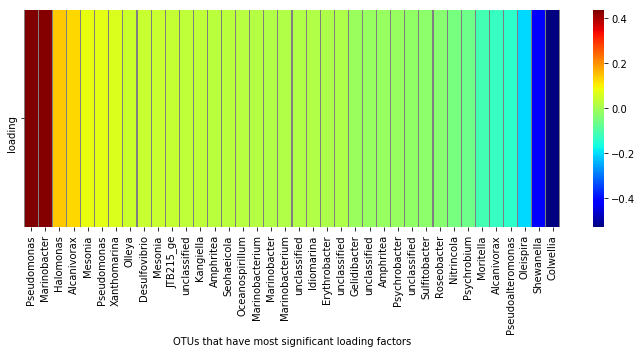

In [229]:
plot_heatmapPCA(PCA2_otu_pos,PCA2_otu_neg,'Genus')
plt.xlabel("OTUs that have most significant loading factors",labelpad=3)

In [192]:
datatomodel=datatomodel.sort_values(by='WD',ascending=False)

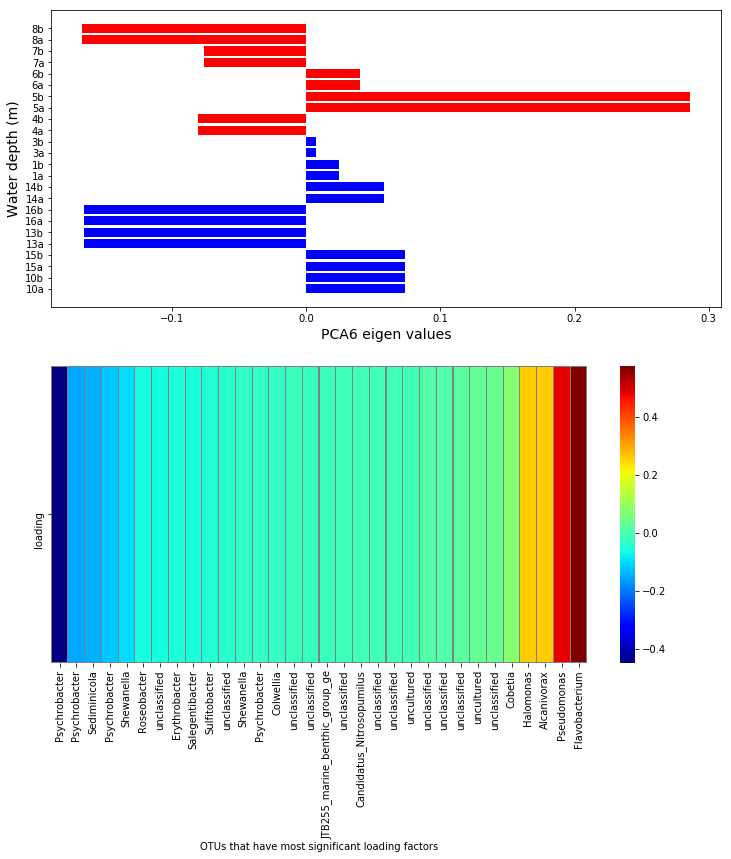

In [263]:
plt.figure(figsize=(12,12))
#f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]})

plt.subplot(2,1,1)
plt.barh(test_all['Sample'],test_all['PCA6'],color=np.repeat(['blue','red'],[14,10]))
plt.xlabel("PCA6 eigen values",fontsize=14)
#f=plt.yticks(np.arange(0,24),datatomodel['Sample'].astype(int))
plt.ylabel('Water depth (m)',fontsize=14)
plt.subplot(2,1,2)
#plt.figure(figsize=(12,4))
sns.heatmap(plot_heatmapPCA(PCA3_otu_neg,PCA3_otu_pos,'Genus').astype(float),cmap='jet',linecolor='grey',linewidths=0.1)
plt.xlabel("OTUs that have most significant loading factors",labelpad=3)
plt.savefig("PCA6_eigenvalues",dpi=300)

In [52]:
alk_features = np.sort(rf.feature_importances_)

In [59]:
pah_features = np.sort(rf.feature_importances_)

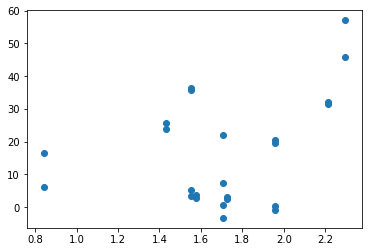

In [65]:
plt.scatter(datatomodel['TOC'],datatomodel['PAH'])

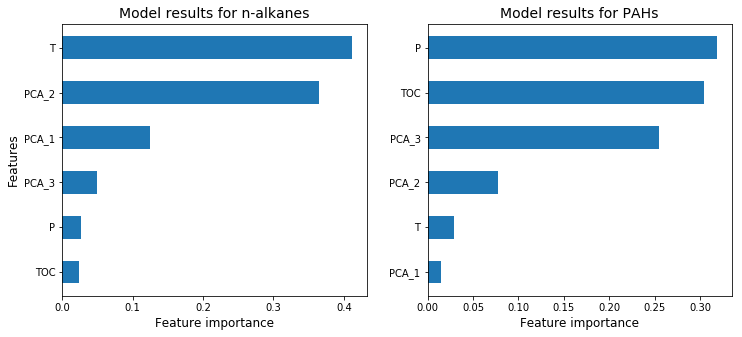

In [60]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.barh(['TOC','P','PCA_3','PCA_1','PCA_2','T'],alk_features,height=[0.5])
plt.xlabel('Feature importance',fontsize=12)
plt.xticks(np.arange(5)/10,np.arange(5)/10)
plt.ylabel("Features",fontsize=12)
plt.title("Model results for n-alkanes",fontsize=14)
plt.subplot(1,2,2)
plt.barh(['PCA_1','T','PCA_2','PCA_3','TOC','P'],pah_features,height=[0.5])
plt.xlabel('Feature importance',fontsize=12)
plt.title("Model results for PAHs",fontsize=14)
plt.savefig("Model_features.png",bbox_inches='tight',dpi=300)

In [726]:
alk_features = np.sort(rf.feature_importances_)

In [498]:
OTU_mat = samples_merge.drop(['ALK','PAH','T','P'],1).set_index('Sample').as_matrix()

In [502]:
from sklearn.metrics.pairwise import pairwise_distances
import skbio 
from sklearn import manifold
from skbio import DistanceMatrix
bc_dm = pairwise_distances(OTU_mat,metric="braycurtis")
dm = DistanceMatrix(bc_dm)

In [503]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=101,
                       dissimilarity="precomputed", n_jobs=1)

In [510]:
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12,
                        dissimilarity="precomputed", random_state=101, n_jobs=1,
                        n_init=1)
npos = nmds.fit_transform(bc_dm, init=pos)

In [504]:
pos = mds.fit(bc_dm).embedding_

In [520]:
nmds.

0

### Model with genus abudant data <a class="anchor" id="V2"></a>

In [3]:
# Import abundance data (calculated from R)
genus = pd.read_csv('oil_genus_all.csv',index_col=0)
genus_nona = genus.fillna(0)
genus.head()

,OTU,Sample,Abundance,Group,Site,P,T,WD,TOC,Carb,...,ALK,PAH,Pressure_regime,Temperature_regime,Kingdom,Phylum,Class,Order,Family,Genus
0,Otu02939,8orig,0.000564,8orig,SL9150,2.5,10.0,251.0,2.214079,32.1,...,NaN,NaN,Low P,High T,Bacteria,Planctomycetes,028H05-P-BN-P5,028H05-P-BN-P5_or,028H05-P-BN-P5_fa,028H05-P-BN-P5_ge
1,Otu02939,13c,0.000473,13c,DSH10,0.1,4.0,1520.0,1.551581,20.3,...,0.0,0.000000,High P,Low T,Bacteria,Planctomycetes,028H05-P-BN-P5,028H05-P-BN-P5_or,028H05-P-BN-P5_fa,028H05-P-BN-P5_ge
2,Otu02939,8c,0.000325,8c,SL9150,0.1,4.0,251.0,2.214079,32.1,...,0.0,0.000000,Low P,High T,Bacteria,Planctomycetes,028H05-P-BN-P5,028H05-P-BN-P5_or,028H05-P-BN-P5_fa,028H05-P-BN-P5_ge
3,Otu02939,4orig,0.000261,4orig,SL1460,2.5,20.0,212.0,1.433782,43.8,...,NaN,NaN,Low P,High T,Bacteria,Planctomycetes,028H05-P-BN-P5,028H05-P-BN-P5_or,028H05-P-BN-P5_fa,028H05-P-BN-P5_ge
4,Otu02939,1b,0.000187,1b,DSH08,11.1,4.0,1127.0,1.959001,26.1,...,60.0,19.525762,High P,Low T,Bacteria,Planctomycetes,028H05-P-BN-P5,028H05-P-BN-P5_or,028H05-P-BN-P5_fa,028H05-P-BN-P5_ge


In [286]:
samples = genus[(genus['Type'].isin(['sample','dummy']))&(genus['WD']>900)&(genus['Genus']!='unknown')]
samples_pivot = pd.pivot_table(samples,values='Abundance',columns='Sample',index='Genus',aggfunc='sum')

In [288]:
genera = []
for i in samples_pivot.T.index:
    genera += list(samples_pivot.T.loc[i][samples_pivot.T.loc[i]>0.01].index)
genera = list(set(genera))
genera.sort()

In [289]:
len(genera)

20

In [290]:
samples_select = samples_pivot.loc[genera]
samples_select_T = samples_select.T.reset_index()
samples_merge = pd.merge(samples_select_T,samples[['Sample','T','P','ALK','PAH','WD']],how='left',on=['Sample'])
samples_merge.drop_duplicates(inplace=True)
samples_merge.shape

Text(0,0.5,'Second Principal Component')

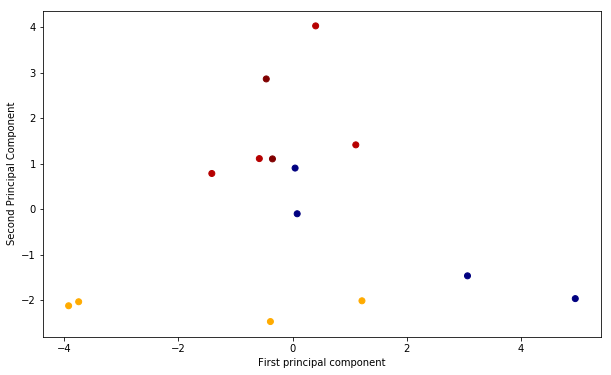

In [293]:
scaler = StandardScaler()
scaler.fit(samples_merge.drop(['Sample','T','P','ALK','PAH','WD'],1))
scaled_data = scaler.transform(samples_merge.drop(['Sample','T','P','ALK','PAH','WD'],1))
pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
plt.figure(figsize=(10,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=np.array(-samples_merge['WD']),cmap='jet')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [294]:
df_comp = pd.DataFrame(pca.components_,columns=samples_merge.drop(['Sample','T','P','ALK','PAH','WD'],1).columns)

In [296]:
df_comp.loc[1][df_comp.loc[1]>0.3]


Halomonadaceae_ge    0.394057
Idiomarina           0.417979
Moritella            0.312068
Nitrincola           0.337766
Shewanella           0.319609
Name: 1, dtype: float64

In [297]:
df_comp.loc[1][df_comp.loc[1]<-0.2]


Alcanivorax         -0.240045
Amphritea           -0.257084
Pseudoalteromonas   -0.233098
Name: 1, dtype: float64

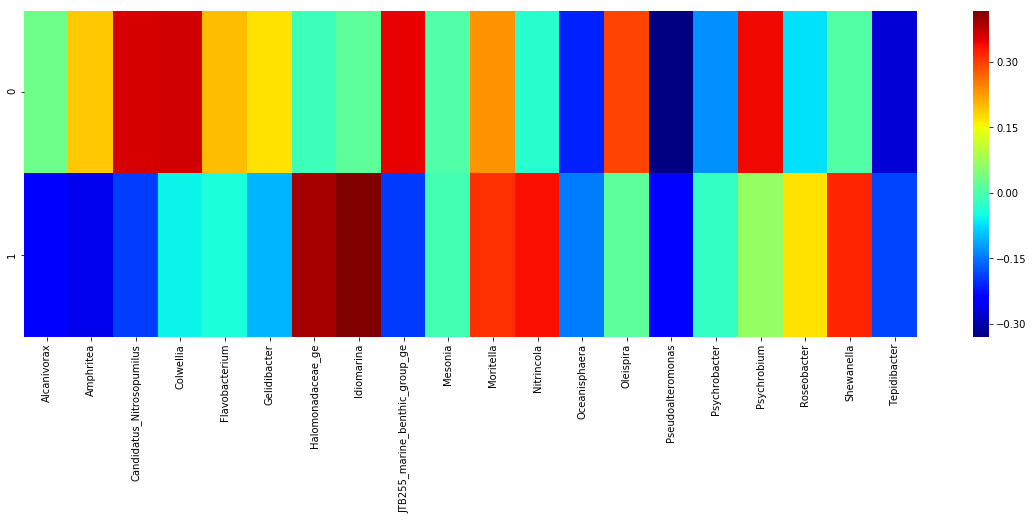

In [298]:
plt.figure(figsize=(20,6))
sns.heatmap(df_comp,cmap='jet')

In [299]:
samples_merge['PCA1']=x_pca[:,0]
samples_merge['PCA2']=x_pca[:,1]

In [304]:
X_train, X_test, y_train, y_test = train_test_split(samples_merge[['PCA1','PCA2','P']], samples_merge['PAH'],
                                                                  test_size=0, random_state=42)

In [305]:
rf = RandomForestRegressor(n_estimators=5000,oob_score=True)
rf.fit(X_train,y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [306]:
rf.feature_importances_

array([ 0.21543356,  0.12062637,  0.66394006])

In [307]:
#y_pred = rf.predict(X_test)
#print(mean_squared_error(y_test,y_pred))
print(rf.oob_score_)

0.588243202189
